In [282]:
# encoding: utf-8
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from textblob import TextBlob, Word
from nltk.stem.snowball import SnowballStemmer


import plotly.plotly as py
import plotly.tools as tls
tls.embed('https://plot.ly/~cufflinks/8')
import cufflinks as cf

py.sign_in('maxrose', '••••••••••')

cf.set_config_file(offline=True, world_readable=False, theme='ggplot')

plt.rcParams['figure.figsize'] = 8, 6

### Frame with all cover versions
covers = pd.read_table('data/bs_covers.csv', encoding= 'utf-8',header=0,delimiter='|')

### Frame with workid and is_cover (written by either Beatles or Stones)
is_cover = pd.read_csv("data/work_cover.csv")

### Frame with source data for all recordings by Beatle and stones
bs = pd.read_table('data/allalbums_newmeta2.csv', encoding= 'utf-8',header=0,delimiter='|')
### fix releasedate
bs.set_value(bs.releasename.str.contains("Meet The Beatles"), 'releasedate', '1964-01-20')
### format releasedate as datetime
bs['releasedate'] = pd.to_datetime(pd.Series(bs.releasedate))
#bs.head(4)

In [283]:
# Update various data mistakes - better web-scraping matches for lyrics
bs.set_value(bs.songname.str.contains('Keep'), 'songname', 'Keep Your Hands Off My Baby')
bs.set_value(bs.songname.str.contains('Baby You’re a Rich Man'), 'songname', 'Baby, You’re a Rich Man')
bs.set_value(bs.songname.str.contains("It's Only Rock 'n' Roll (but I Like It)"), 'songname', "It's Only Rock 'n Roll (But I Like It)")
bs.set_value(bs.songname.str.contains("When I’m Sixty‐Four"), 'songname', "When I'm Sixty-Four")
bs.set_value(bs.songname.str.contains("Ob‐La‐Di, Ob‐La‐Da"), 'songname', "Ob-La-Di, Ob-La-Da")
bs.set_value(bs.songname.str.contains("Sure To Fall"), 'songname', "Sure To Fall (In Love With You)")
bs.set_value(bs.songname.str.contains("Honey, Don’t!"), 'songname', "Honey, Don’t")
bs.set_value(bs.songname.str.contains("Love in Vain Blues"), 'songname', "Love in Vain")
# Replace bad unicode character to apostrophe.
bs.replace(u"\xe2", "'")


/Users/maxrose/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: UserWarning:

This pattern has match groups. To actually get the groups, use str.extract.



,artistid,artist,songname,releasename,workid,recordingid,release_group,releasedate,label_cnt,country_cnt,rating
0,303,The Beatles,A Taste of Honey,1962 Live Recordings,295302,4732310,420949,1962-01-01,1,1,0
1,303,The Beatles,Ask Me Why,1962 Live Recordings,295296,4732323,420949,1962-01-01,1,1,0
2,303,The Beatles,Be-Bop-A-Lula,1962 Live Recordings,8387505,4732321,420949,1962-01-01,1,1,0
3,303,The Beatles,Everybody’s Trying to Be My Baby,1962 Live Recordings,368508,4732314,420949,1962-01-01,1,1,0
4,303,The Beatles,Falling in Love Again (Can’t Help It),1962 Live Recordings,2374813,4732319,420949,1962-01-01,1,1,0
5,303,The Beatles,"Hallelujah, I Love Her So",1962 Live Recordings,2648186,4732322,420949,1962-01-01,1,1,0
6,303,The Beatles,Hippy Hippy Shake,1962 Live Recordings,6569228,4732303,420949,1962-01-01,1,1,0
7,303,The Beatles,I Remember You,1962 Live Recordings,506842,4732329,420949,1962-01-01,1,1,0
8,303,The Beatles,I Saw Her Standing There,1962 Live Recordings,295291,4732300,420949,1962-01-01,1,1,0
9,303,The Beatles,I Wish I Could Shimmy Like My Sister Kate,1962 Live Recordings,12516025,4732327,420949,1962-01-01,1,1,0


In [284]:
### Add Times recorded for each song
vc = pd.DataFrame(bs.songname.value_counts().reset_index())
vc.columns = ['songname', 'timesrec']
bs = pd.merge(bs, vc, on='songname')

In [ ]:
print bs.shape
print bs.describe()
print covers.shape
print covers.describe()


In [285]:
### aggregations for Beatles and Rolling Stones recordings
aggregations = {
    'releasename':{'num_releases':'count'}
    ,'releasedate':{'maxreleasedate':'min'}
    ,'rating': {'avg_rating':'min'}
    ,'country_cnt':{'countries':'nunique'}
    #,'songname': {'times_rec':'value_counts'}
}
#bsagg = bs.groupby(['workid', 'artist', 'songname', 'releasename','release_group','releasedate']).agg(aggregations).reset_index()
bsagg = bs.groupby(['workid', 'artist', 'songname']).agg(aggregations).reset_index()
bsagg.columns = bsagg.columns.droplevel(1)
bsagg.columns = ['workid','artist','songname','minreleasedate','num_releases','countries','avg_rating']

In [286]:
### Prepare for scraping Lyrics
# encoding: utf-8
import requests as req
from urllib import quote_plus
from bs4 import BeautifulSoup, SoupStrainer
only_lyrics = SoupStrainer('div',class_='lyricbox')

In [287]:
### Funtion for scraping lyrics from Wikia
baseurl = 'http://lyrics.wikia.com/wiki/'
def getLyrics(workid,artist, song):
    #ssong = song.replace("’", "'")
    #print ssong
    tUrl = "%s%s:%s" %(baseurl,artist,song)
    result = req.get(tUrl)
    lyric = BeautifulSoup(result.text, 'html.parser', parse_only=only_lyrics).get_text(' ',strip=True)
    #lyrics.append(workid, song, lyric)
    return lyric


In [288]:
### Get lyrics for each song, add to aggregated data
lyrics = []
for idx, row in bsagg.iterrows():
    lyrics.append(getLyrics(row.workid, row.artist, row.songname))
bsagg['lyrics'] = lyrics

In [289]:
### Get sentiment of text
def detect_sentiment(text):
    return TextBlob(text).sentiment.polarity

In [290]:
### Add sentiment of songname, lyrics to aggregated data
bsagg['title_sent'] = bsagg.songname.apply(detect_sentiment)
bsagg['lyric_sent'] = bsagg.lyrics.apply(detect_sentiment)

In [291]:
### clean up covers dataframe

covers['src_id'] = covers.source_artist.map({303:0,825:1}) 
#covers.drop(['srcid'], axis = 1, inplace = True)

### fill missing ratings with mean for workid where ratings exist.
means = covers[covers.rating > 0].groupby('workid').rating.mean()
covers = covers.set_index(['workid'])
covers['rating'] = covers['rating'].fillna(means)
covers = covers.reset_index()
### Fill with 0 where no ratings exist for this cover song.
covers.rating.fillna(0, inplace=True)

In [ ]:
covers.head()

In [293]:
### Aggregations for covers

aggregations = {
    'recording_id':{'times_covered':'count'}
    ,'rec_artist_id':{'artist_cnt':'nunique'}
    ,'rating': {'cov_rating_avg':'mean'}
}

coversagg = covers.groupby(['workid']).agg(aggregations).reset_index()
coversagg.columns = coversagg.columns.droplevel(1)
coversagg.columns = ['workid','artist_cnt','cov_rating_avg','times_covered']
coversagg.shape

(221, 4)

In [294]:
### merge dataframes for analysis
### adding is_cover binary
bsagg = bsagg.merge(is_cover[['workid', 'is_cover']], on=['workid'])
### adding cover aggregates
bsagg = bsagg.merge(coversagg[['workid','artist_cnt','cov_rating_avg','times_covered']], how='left', on=['workid'])

In [ ]:
import plotly
plotly.offline.iplot([{
    'x': bsagg.num_releases,
    'y': bsagg.avg_rating
    
}])

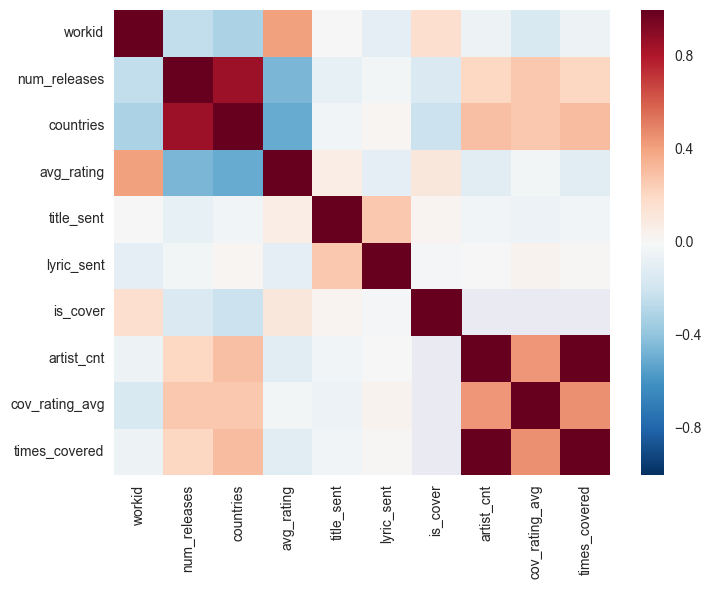

In [303]:
sns.heatmap(bsagg.corr())

In [302]:
bsagg.shape

(374, 14)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11fec1990>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x126c2b8d0>]], dtype=object)

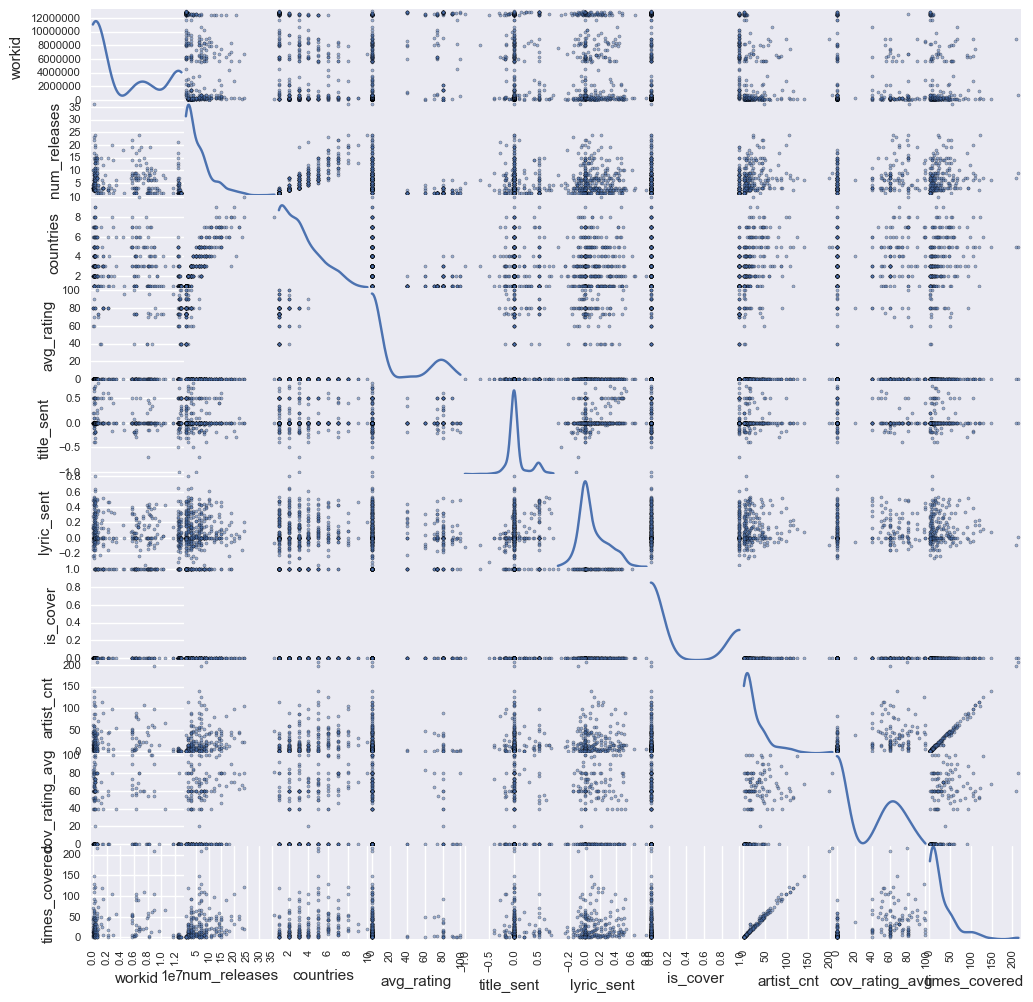

In [304]:
from pandas.tools.plotting import scatter_matrix
scatter_matrix(bsagg, alpha=0.5, figsize=(12, 12), diagonal='kde')

In [317]:
### Export cleaned data to csv for use in separate notebook.
bsagg.to_csv('data/Influence_clean.csv',sep='|',encoding='utf-8',index=False)